##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
from skimage import io
import cv2
import os
import PIL
import tensorflow_datasets as tfds

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from google.colab import drive

### Download and prepare the CIFAR10 dataset

Download dataset from google drive for training.

In [ ]:
drive.mount('/content/gdrive/')
path = 'gdrive/MyDrive/CIFAR-10_2/train'

Mounted at /content/gdrive/


In [ ]:
# train_path = 'gdrive/MyDrive/CIFAR-10_2/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(32, 32))

Found 5000 files belonging to 5 classes.
Using 4000 files for training.


In [ ]:
# test_path = 'gdrive/MyDrive/CIFAR-10_2/test'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(32, 32))

Found 5000 files belonging to 5 classes.
Using 1000 files for validation.


In [ ]:
class_names = train_ds.class_names;
class_names

['airplane', 'automobile', 'bird', 'cat', 'deer']

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch)
  break

(32, 32, 32, 3)
tf.Tensor([1 1 1 2 0 3 4 1 0 0 1 0 1 4 1 2 0 2 0 4 3 0 1 3 0 3 3 1 2 1 0 0], shape=(32,), dtype=int32)


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


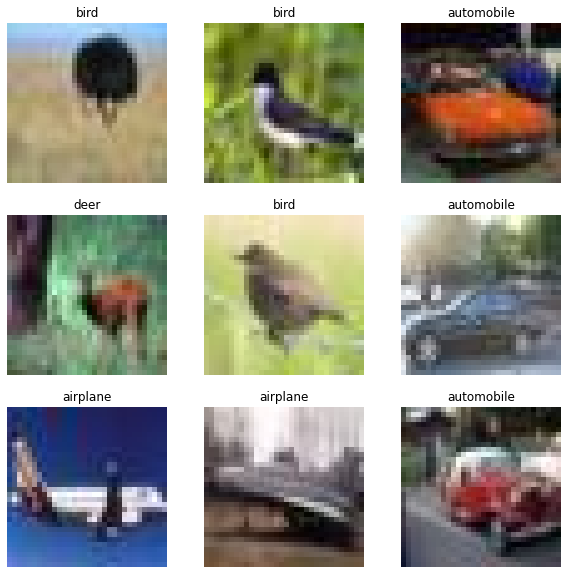

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.07450981 0.9921569
0.023529414 1.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32, 3)))
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
__________________________________________________

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

Here's the complete architecture of your model:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)             

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

At first epoch, colab will convert image files to numpy array

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  train_ds,
  batch_size=32,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
125/125 [==============================] - 5s 32ms/step - loss: 0.6515 - accuracy: 0.7517 - val_loss: 0.8943 - val_accuracy: 0.6610
Epoch 2/10
125/125 [==============================] - 4s 31ms/step - loss: 0.6114 - accuracy: 0.7675 - val_loss: 0.9146 - val_accuracy: 0.6520
Epoch 3/10
125/125 [==============================] - 4s 32ms/step - loss: 0.5764 - accuracy: 0.7765 - val_loss: 0.8925 - val_accuracy: 0.6790
Epoch 4/10
125/125 [==============================] - 4s 31ms/step - loss: 0.5295 - accuracy: 0.7955 - val_loss: 0.8867 - val_accuracy: 0.6620
Epoch 5/10
125/125 [==============================] - 4s 31ms/step - loss: 0.4878 - accuracy: 0.8130 - val_loss: 0.9042 - val_accuracy: 0.6730
Epoch 6/10
125/125 [==============================] - 4s 31ms/step - loss: 0.4526 - accuracy: 0.8317 - val_loss: 0.9729 - val_accuracy: 0.6660
Epoch 7/10
125/125 [==============================] - 4s 31ms/step - loss: 0.4118 - accuracy: 0.8503 - val_loss: 0.9937 - val_accuracy: 0.6800

### Evaluate the model

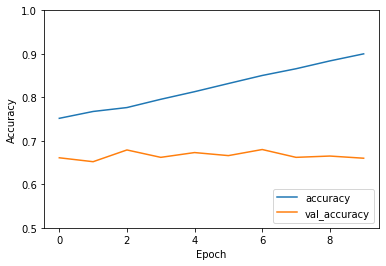

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

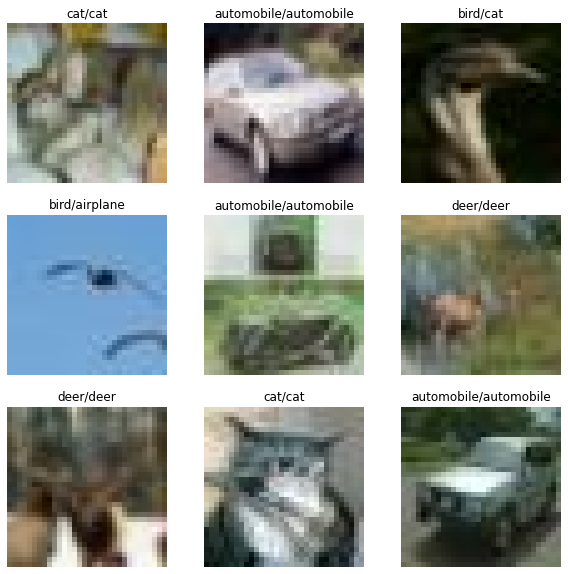

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    a = (model.predict(images))
    plt.title(class_names[labels[i]] + '/' + class_names[tf.argmax(a[i])])
    plt.axis("off")

Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.